# custom classification problem

## imports

In [140]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## data
The data we're trying to classify will consist of 2 datasets. One will be a small square centered at 0, 0. The other will consist of a border surrouding the inner square.

In [133]:
class1_size = 500
class1_radius = 3
class2_size = 500

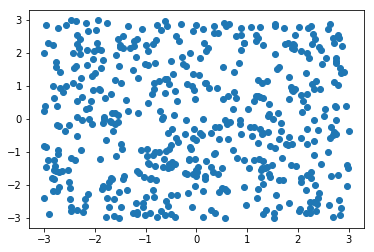

In [134]:
features1 = np.random.uniform(low=-class1_radius, high=class1_radius, size=(class1_size, 2))
plt.plot(features1[:,0], features1[:,1], "o")

In [135]:
def get_features2(num_points=10, point_lim=100, top_left=[-1, 1], bottom_right=[-1, 1]):
    """
    Attempts to get num_points random data points that exist
    outside of the box described by top_left, bottom_right. The
    function will continue until num_points have been acquired or
    until point_lim has been reached. If point_lim is reached,
    the data points acquired so far will be returned.
    :param num_points: Desired number of data points
    :param point_lim: Desired stopping criteria for total points
        (including invalid points) generated
    :param top_left: Describes the top_left of the inner box in
        [] indexable form
    :param top_right: Describes the top_right of the inner box in
        [] indexable form
    """
    #outer bounds for data array
    top_left_bound = [e * 2 for e in top_left]
    bottom_right_bound = [e * 2 for e in bottom_right]
    max_x = np.max([np.abs(top_left_bound[0]), np.abs(bottom_right_bound[0])])
    max_y = np.max([np.abs(top_left_bound[1]), np.abs(bottom_right_bound[1])])
    print(top_left, bottom_right)
    print(top_left_bound, bottom_right_bound)
    print(max_x, max_y)
    #inner bounds are described by top_left and bottom_right
    
    points = []
    #collect points
    for i in range(point_lim):
        px = np.random.uniform(low=-max_x, high=max_x)
        py = np.random.uniform(low=-max_y, high=max_y)
        
        #check if point valid
        valid_x = px < top_left[0] or bottom_right[0] < px
        valid_y = top_left[1] < py or py < bottom_right[1]
        if valid_x or valid_y:
            points.append([px, py])
        
        #check if enough points
        if len(points) == num_points:
            break
    return np.asarray(points)

[-3, 3] [3, -3]
[-6, 6] [6, -6]
6 6


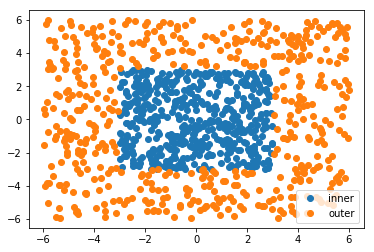

In [136]:
features2 = get_features2(
    num_points=class2_size,
    point_lim=2*class2_size,
    top_left=[-class1_radius, class1_radius],
    bottom_right=[class1_radius, -class1_radius]
)
plt.plot(features1[:,0], features1[:,1], "o", label="inner")
plt.plot(features2[:,0], features2[:,1], "o", label="outer")
plt.legend()

### dataframe-izing
We'll now attach the data into a pandas dataframe.

In [137]:
df1 = pd.DataFrame(features1, columns=["x", "y"])
df1["label"] = 0
df1.head(3)

,x,y,label
0,2.018087,2.778710,0
1,1.896394,0.838430,0
2,0.622010,0.698046,0


In [138]:
df2 = pd.DataFrame(features2, columns=["x", "y"])
df2["label"] = 1
df2.head(3)

,x,y,label
0,0.329932,-3.258074,1
1,-0.941108,4.130960,1
2,-0.233279,-5.125008,1


In [150]:
df = pd.concat([df1, df2], axis=0, ignore_index=True)
df.sample(n=6)

,x,y,label
910,-2.609259,-5.917485,1
386,0.441771,-2.200361,0
772,-5.137253,5.030403,1
424,0.596806,-0.139146,0
162,2.833805,-2.916616,0
567,-2.248641,4.653681,1


## scaling data
We'll scale the features below using a min-max scaler.

In [153]:
df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df[df.columns[:-1]]), columns=["x", "y"])
df_scaled["label"] = df["label"]
df_scaled.sample(6)

,x,y,label
101,0.434319,0.736840,0
739,0.807215,0.157588,1
799,0.084211,0.504422,1
352,0.502332,0.375741,0
8,0.639464,0.467930,0
83,0.607553,0.459803,0


## defining feature columns
All of these features are numeric, so there will be no categorical columns.

In [156]:
feature_columns = []
for c in df_scaled.columns[:-1]:
    feature_columns.append(tf.feature_column.numeric_column(c))
feature_columns

[_NumericColumn(key='x', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='y', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

## splitting the data
Now we'll split the data into train/test sets.

In [157]:
test_size = 0.2
random_state = 0

In [162]:
x_train, x_test, y_train, y_test = train_test_split(
    df_scaled[df_scaled.columns[:-1]],
    df_scaled[df_scaled.columns[-1]],
    test_size=test_size,
    random_state=random_state
)

## linear classifier
Below we'll try and fit the data to a linear classifier.
### input function
We'll define the input function for training the estimator.

In [192]:
batch_size = 16
num_epochs=1000

In [193]:
input_fn_train = tf.estimator.inputs.pandas_input_fn(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    num_epochs=num_epochs,
    shuffle=True
)

### model definition
Let's declare the model.

In [194]:
model = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=len(df_scaled["label"].unique())
)
model.train(input_fn_train, steps=num_epochs)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_model_dir': 'C:\\Users\\unknown\\AppData\\Local\\Temp\\tmp95xtjev9', '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_session_config': None, '_tf_random_seed': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\unknown\AppData\Local\Temp\tmp95xtjev9\model.ckpt.
INFO:tensorflow:loss = 11.0904, step = 1
INFO:tensorflow:global_step/sec: 1090.23
INFO:tensorflow:loss = 10.9215, step = 101 (0.092 sec)
INFO:tensorflow:global_step/sec: 1193.66
INFO:tensorflow:loss = 11.0798, step = 201 (0.084 sec)
INFO:tensorflow:global_step/sec: 1253.33
INFO:tensorflow:loss = 11.3547, step = 301 (0.080 sec)
INFO:tensorflow:global_step/sec: 1236.89
INFO:tensorflow:loss = 10.8654, step = 401 (0.081 sec)
INFO:tensorflow:global_step/sec: 1232.39
INFO:te

### evaluation and predictions
Now we can grab predictions from our model and evaluate it's performance on the test set.

In [195]:
input_fn_test = tf.estimator.inputs.pandas_input_fn(
    x=x_test,
    y=y_test,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=False
)

#### metrics

In [196]:
lc_results = model.evaluate(input_fn_test)
lc_results

INFO:tensorflow:Starting evaluation at 2018-06-05-23:31:27
INFO:tensorflow:Restoring parameters from C:\Users\unknown\AppData\Local\Temp\tmp95xtjev9\model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-06-05-23:31:27
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.355, accuracy_baseline = 0.51, auc = 0.490296, auc_precision_recall = 0.645157, average_loss = 0.693479, global_step = 1000, label/mean = 0.51, loss = 10.6689, prediction/mean = 0.514535


{'accuracy': 0.35499999,
 'accuracy_baseline': 0.50999999,
 'auc': 0.49029613,
 'auc_precision_recall': 0.64515728,
 'average_loss': 0.69347924,
 'global_step': 1000,
 'label/mean': 0.50999999,
 'loss': 10.668911,
 'prediction/mean': 0.51453459}

#### predictions

In [197]:
input_fn_pred = tf.estimator.inputs.pandas_input_fn(
    x=x_test,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=False
)
lc_preds = list(model.predict(input_fn_pred))
lc_preds

INFO:tensorflow:Restoring parameters from C:\Users\unknown\AppData\Local\Temp\tmp95xtjev9\model.ckpt-1000


[{'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.49092764], dtype=float32),
  'logits': array([-0.03629341], dtype=float32),
  'probabilities': array([ 0.50907236,  0.49092767], dtype=float32)},
 {'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.53097689], dtype=float32),
  'logits': array([ 0.12406654], dtype=float32),
  'probabilities': array([ 0.46902305,  0.53097689], dtype=float32)},
 {'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.50454253], dtype=float32),
  'logits': array([ 0.0181706], dtype=float32),
  'probabilities': array([ 0.49545747,  0.50454253], dtype=float32)},
 {'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.52475959], dtype=float32),
  'logits': array([ 0.09911932], dtype=float32),
  'probabilities': array([ 0.47524047,  0.52475959], dtype=floa

In [246]:
lc_preds_simple = list(map(lambda x: int(x["classes"][0].decode()), lc_preds))
lc_preds_simple

[0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1]

### visualization
Let's visualize the results on the test set.

In [247]:
df_lc = pd.concat([x_test, y_test], axis=1)
df_lc.columns = ["x", "y", "actual"]
df_lc = df_lc.reset_index(drop=True)
df_lc.head(4)

,x,y,actual
0,0.373495,0.033745,1
1,0.814249,0.879235,1
2,0.662924,0.379541,0
3,0.989186,0.849885,1


In [248]:
df_lc["pred"] = lc_preds_simple
df_lc.head(4)

,x,y,actual,pred
0,0.373495,0.033745,1,0
1,0.814249,0.879235,1,1
2,0.662924,0.379541,0,1
3,0.989186,0.849885,1,1


In [254]:
lc_actual0 = df_lc[df_lc["actual"] == 0]
lc_actual1 = df_lc[df_lc["actual"] == 1]
lc_pred0 = df_lc[df_lc["pred"] == 0]
lc_pred1 = df_lc[df_lc["pred"] == 1]

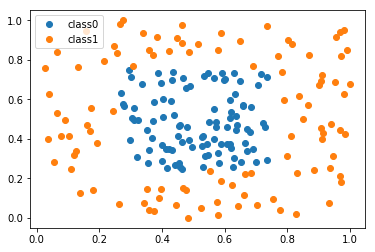

In [257]:
#plotting real
plt.plot(lc_actual0["x"], lc_actual0["y"], "o", label="class0")
plt.plot(lc_actual1["x"], lc_actual1["y"], "o", label="class1")
plt.legend()

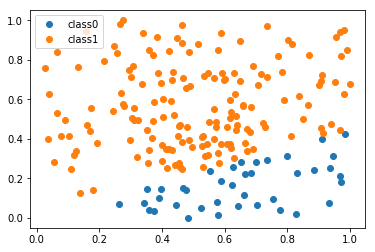

In [256]:
#plotting predicted
plt.plot(lc_pred0["x"], lc_pred0["y"], "o", label="class0")
plt.plot(lc_pred1["x"], lc_pred1["y"], "o", label="class1")
plt.legend()

## thoughts on linear classifier
Looking at the work above, it seems as though the linear classifier was not able to learn the data pattern. This could be for a number of reasons (insufficient test size and class variability, for example). However, it's most likely that this data cannot be learned by a linear classifier.

## dnn classifier
Instead, let's try a dense neural network to attack this classification problem.

### model

In [267]:
dnn_model = tf.estimator.DNNClassifier(
    hidden_units=[10]*3,
    feature_columns=feature_columns,
    n_classes=len(df_scaled["label"].unique())
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_model_dir': 'C:\\Users\\unknown\\AppData\\Local\\Temp\\tmp02vm2mmm', '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_session_config': None, '_tf_random_seed': 1}


### training

In [268]:
input_fn_dnn_train = tf.estimator.inputs.pandas_input_fn(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    num_epochs=num_epochs, shuffle=True
)
dnn_model.train(input_fn=input_fn_dnn_train, steps=num_epochs)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\unknown\AppData\Local\Temp\tmp02vm2mmm\model.ckpt.
INFO:tensorflow:loss = 11.1219, step = 1
INFO:tensorflow:global_step/sec: 1090.22
INFO:tensorflow:loss = 9.95371, step = 101 (0.093 sec)
INFO:tensorflow:global_step/sec: 1319.3
INFO:tensorflow:loss = 8.26822, step = 201 (0.078 sec)
INFO:tensorflow:global_step/sec: 1193.66
INFO:tensorflow:loss = 5.98212, step = 301 (0.082 sec)
INFO:tensorflow:global_step/sec: 1192.77
INFO:tensorflow:loss = 3.75578, step = 401 (0.084 sec)
INFO:tensorflow:global_step/sec: 1191.84
INFO:tensorflow:loss = 4.06926, step = 501 (0.084 sec)
INFO:tensorflow:global_step/sec: 1208.06
INFO:tensorflow:loss = 3.31403, step = 601 (0.084 sec)
INFO:tensorflow:global_step/sec: 1191.32
INFO:tensorflow:loss = 4.93963, step = 701 (0.084 sec)
INFO:tensorflow:global_step/sec: 1319.32
INFO:tensorflow:loss = 4.84887, step = 801 (0.076 sec)
INFO:tensorflow:global_step/sec: 1191.64
I

### evaluation and predictions

In [269]:
input_fn_dnn_eval = tf.estimator.inputs.pandas_input_fn(
    x=x_test,
    y=y_test,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=False
)
dnn_model.evaluate(input_fn=input_fn_dnn_eval)

INFO:tensorflow:Starting evaluation at 2018-06-06-00:03:13
INFO:tensorflow:Restoring parameters from C:\Users\unknown\AppData\Local\Temp\tmp02vm2mmm\model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2018-06-06-00:03:13
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.965, accuracy_baseline = 0.51, auc = 0.9988, auc_precision_recall = 0.998913, average_loss = 0.133338, global_step = 1000, label/mean = 0.51, loss = 2.05135, prediction/mean = 0.490419


{'accuracy': 0.96499997,
 'accuracy_baseline': 0.50999999,
 'auc': 0.9987995,
 'auc_precision_recall': 0.99891257,
 'average_loss': 0.13333789,
 'global_step': 1000,
 'label/mean': 0.50999999,
 'loss': 2.051352,
 'prediction/mean': 0.4904193}

### thoughts so far
Before even visualizing the data, the DNN is classifying with an accuracy of ~96%, which is fantastic.

In [270]:
input_fn_dnn_pred = tf.estimator.inputs.pandas_input_fn(
    x=x_test,
    batch_size=batch_size,
    num_epochs=1,
    shuffle=False
)
dnn_preds = list(dnn_model.predict(input_fn=input_fn_dnn_pred))
dnn_preds

INFO:tensorflow:Restoring parameters from C:\Users\unknown\AppData\Local\Temp\tmp02vm2mmm\model.ckpt-1000


[{'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.99943548], dtype=float32),
  'logits': array([ 7.47891617], dtype=float32),
  'probabilities': array([  5.64550457e-04,   9.99435484e-01], dtype=float32)},
 {'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.96456695], dtype=float32),
  'logits': array([ 3.3040328], dtype=float32),
  'probabilities': array([ 0.0354331 ,  0.96456695], dtype=float32)},
 {'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object),
  'logistic': array([ 0.04250456], dtype=float32),
  'logits': array([-3.11470962], dtype=float32),
  'probabilities': array([ 0.95749545,  0.04250456], dtype=float32)},
 {'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'logistic': array([ 0.9866485], dtype=float32),
  'logits': array([ 4.30268812], dtype=float32),
  'probabilities': array([ 0.01335146,  0.9866485 ], d

In [272]:
dnn_preds_simple = list(map(lambda x: int(x["classes"][0].decode()), dnn_preds))
dnn_preds_simple

[1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0]

## visualization
Let's visualize the results.

In [276]:
df_dnn = pd.concat([x_test, y_test], axis=1)
df_dnn.columns = ["x", "y", "real"]
df_dnn = df_dnn.reset_index(drop=True)
df_dnn["pred"] = dnn_preds_simple
df_dnn.head(20)

,x,y,real,pred
0,0.373495,0.033745,1,1
1,0.814249,0.879235,1,1
2,0.662924,0.379541,0,0
3,0.989186,0.849885,1,1
4,0.481357,0.000000,1,1
5,0.682983,0.227588,1,1
6,0.413043,0.351010,0,0
7,0.715548,0.727729,0,0
8,0.571071,0.484678,0,0
9,0.445914,0.065229,1,1


In [278]:
dnn_real0 = df_dnn[df_dnn["real"] == 0]
dnn_real1 = df_dnn[df_dnn["real"] == 1]
dnn_pred0 = df_dnn[df_dnn["pred"] == 0]
dnn_pred1 = df_dnn[df_dnn["pred"] == 1]

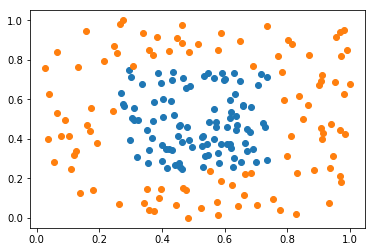

In [283]:
#plotting real
plt.plot(dnn_real0["x"], dnn_real0["y"], "o", label="class0")
plt.plot(dnn_real1["x"], dnn_real1["y"], "o", label="class1")
# plt.legend()

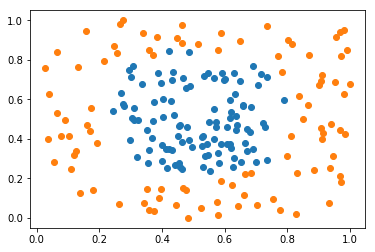

In [282]:
#plotting predicted
plt.plot(dnn_pred0["x"], dnn_pred0["y"], "o", label="class0")
plt.plot(dnn_pred1["x"], dnn_pred1["y"], "o", label="class1")
# plt.legend()

## final thoughts
With respect to model comparison, the DNN is clearly outperforming the linear classifier. Looking at the above 2 plots specifically, it's easy to see that the DNN makes very few misclassifications, and has captured the general shape of the data as well.